<a href="https://colab.research.google.com/github/51rL1N5/Prova_Esig/blob/master/taxi_fare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install kaggle

#!mkdir .kaggle
#import json

#token = {"username":"felipeols","key":"31e9d128303c584a875b2ffd1f394c91"}

#with open('/content/.kaggle/kaggle.json', 'w') as file:
#    json.dump(token, file)
    
    


In [0]:
#!cp -r .kaggle ~/

In [3]:
#!kaggle competitions download -c new-york-city-taxi-fare-prediction

#!unzip \*.zip

  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 44.6MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 58.3MB/s]
 99% 1.55G/1.56G [00:27<00:00, 54.8MB/s]
100% 1.56G/1.56G [00:27<00:00, 60.0MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 439kB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [4]:
#!pip install dask tqdm folium datashader bokeh feather-format

    100% |████████████████████████████████| 12.9MB 3.4MB/s 
    100% |████████████████████████████████| 81kB 18.7MB/s 
    100% |████████████████████████████████| 1.6MB 18.5MB/s 
    100% |████████████████████████████████| 163kB 30.5MB/s 
    100% |████████████████████████████████| 71kB 12.8MB/s 
    100% |████████████████████████████████| 48.5MB 651kB/s 
  Stored in directory: /root/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
Successfully built feather-format datashape
  Found existing installation: testpath 0.4.2
    Uninstalling testpath-0.4.2:
      Successfully uninstalled testpath-0.4.2


In [5]:
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

import dask.dataframe as dd
import os
from tqdm import tqdm


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go


import folium
import folium.plugins

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import optimizers

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()


Using TensorFlow backend.


Loading BokehJS ...

# Carregamento dos dados


---

  O csv que contém os dados é extremamente grande, então precisaremos de uma abordagem mais inteligente e menos "naive" para poder trabalhar com a maior quantidade de dados possível


In [0]:

# sample = pd.read_csv('train.csv', nrows=5)

# sample.head()

In [0]:
# sample.dtypes

Usar um float64 (16 casas decimais) para lear coordenadas/taxa é um excesso de precisão desnecessário que está ocupando muita memória. 

Float32 (7 casas decimais) é suficiente para isso

Bem como no caso do numero de passageiros, int64 é exagero. É suficiente ustilizar uint8, que nos permitirá representar até o numero 2^8 -- que, para o problema, nunca será atingido pela natureza do taxi 

In [0]:
 # Então, vamos forçar que as colunas a terem esses tipos

#datatypes = {
#               'fare_amount': 'float32',
#               'pickup_longitude': 'float32',
#               'pickup_latitude': 'float32',
#               'dropoff_longitude': 'float32',
#               'dropoff_latitude': 'float32',
#               'passenger_count': 'uint8'
#             }
#cols = list(datatypes.keys())
#cols.append('pickup_datetime')
#
#chunksize = 10 ** 6
#
#chunk = pd.read_csv('train.csv', usecols=cols, dtype=datatypes, nrows=chunksize)
#
#
#df_list = []
#
#for df_chunk in pd.read_csv('train.csv', usecols=cols, dtype=datatypes, chunksize=chunksize):
#  
#  df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
#  df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
#   
#  df_list.append(df_chunk) 
#
#df_todo = pd.concat(df_list)
#
#del df_list
#
#
#import feather
# os.makedirs('tmp', exist_ok=True)
#df_todo.to_feather('taxi-train-no-gps.feather')


In [0]:
#chunk = feather.read_dataframe('taxi-train-no-gps.feather').head(chunksize)

In [0]:
# Como o banco de dados é muito grnade, irei analizar-lo por blocos
# Que são suficientemente grandes para podermos supor que representam bem uma aproximação
# da estatística global.

# Logo após processar todos eles, é necessário fazer uma média das análises (estacionaridade)



chunksize = 10 ** 6

chunk = pd.read_csv('../input/train.csv', nrows=chunksize)

In [10]:
# Olhando a cara dos dados

chunk.head()

key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [0]:
# Primeiro, vamos limpar os dados 

"""
----- Limpeza de coordenadas -------------

Sei que a latitude é um número limitado entre -90 <= lat <= 90  
Bem como a longitude é limitada entre -180 <= long <= 180

Então, irei eliminar dados que apresentarem esses dados expúrios

"""

chunk = chunk[
               ( abs(chunk['pickup_latitude']) <= 90 ) & ( abs(chunk['pickup_longitude']) <= 180 ) & ( abs(chunk['dropoff_latitude']) <= 90 ) & ( abs(chunk['dropoff_longitude']) <= 180 )
             ]

"""
----- Limpeza de taxas -------------------

Não faz sentido que tenhamos preço pago negativo
Logo, eliminaremos os dados que possuam tal característica

Também, a taxa inicial (base) de uma viagem de taxi é 2.50 então vamos eliminar todos os dados que estão abaixo de 2.50

"""

chunk = chunk[
               (chunk['fare_amount'] >= 2.50)
             ]

"""
----- Limpeza do número de passageiros ------

De acordo com https://www1.nyc.gov/nyc-resources/faq/484/how-many-passengers-are-allowed-in-a-taxi

No máximo 4 ou 5, acrescido de uma criança abaixo de 7 anos (que ficará no colo de um adulto) poderão ir no taxi

Logo, no máximo teremos 6 passageiros
"""

chunk = chunk[
               (chunk['passenger_count'] <=6)
             ]

"""
----- Remover, caso existam, dados nulos (faltantes) -------------
"""
chunk = chunk.drop(chunk[chunk.isnull().any(1)].index, axis=0)

chunk = chunk.reset_index(drop=True)

Como temos dados que dependem de localizações, precisamos garantir que eles se encontram em localizações válidas. 

A partir desse site (https://www.travelmath.com/cities/New+York,+NY) vemos que as coordenadas da cidade de NY:

Latitude    =  40.7141667

Longitude = -74.0063889

Então, vamos ver como estão dispostos os pontos para saber se existe alguma irregularidade 

In [0]:
# Carregar o mapa

nyc_mapa = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')


# definir limites do mapa
# BB é Boundary Box
# E as componentes dele serão
# [ Limite inferior da longitude, limite superior da longitude, limite inferior da latitude, limite superior da latitude]

BB = (-74.5, -72.8, 40.5, 41.8)

BB_zoom = (-74.3, -73.7, 40.5, 40.9)


nyc_mapa_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [0]:
def filtrar_pela_BB (df, BB):
  return df[(df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
           ]

In [0]:
# Função para podermos plotar os dados no mapa

def plot_on_map(df, BB, mapa, s=10, alpha=0.2):
  fig, axs = plt.subplots(1, 2, figsize=(20,10))
  axs[0].scatter(df['pickup_longitude'], df['pickup_latitude'], zorder=1, alpha=alpha, c='r', s=s)
  axs[0].set_xlim((BB[0], BB[1]))
  axs[0].set_ylim((BB[2], BB[3]))
  axs[0].set_title('Pickup locations')
  axs[0].imshow(mapa, zorder=0, extent=BB)

  axs[1].scatter(df['dropoff_longitude'], df['dropoff_latitude'], zorder=1, alpha=alpha, c='r', s=s)
  axs[1].set_xlim((BB[0], BB[1]))
  axs[1].set_ylim((BB[2], BB[3]))
  axs[1].set_title('Dropoff locations')
  axs[1].imshow(mapa, zorder=0, extent=BB)
  

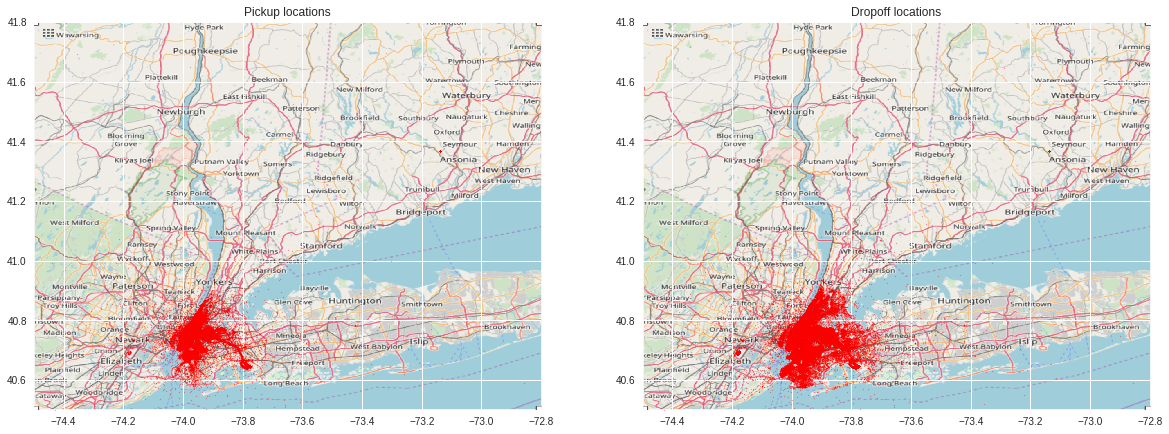

In [15]:
dados_BB = filtrar_pela_BB(chunk, BB)

plot_on_map(dados_BB, BB, nyc_mapa, s=1, alpha=0.3)

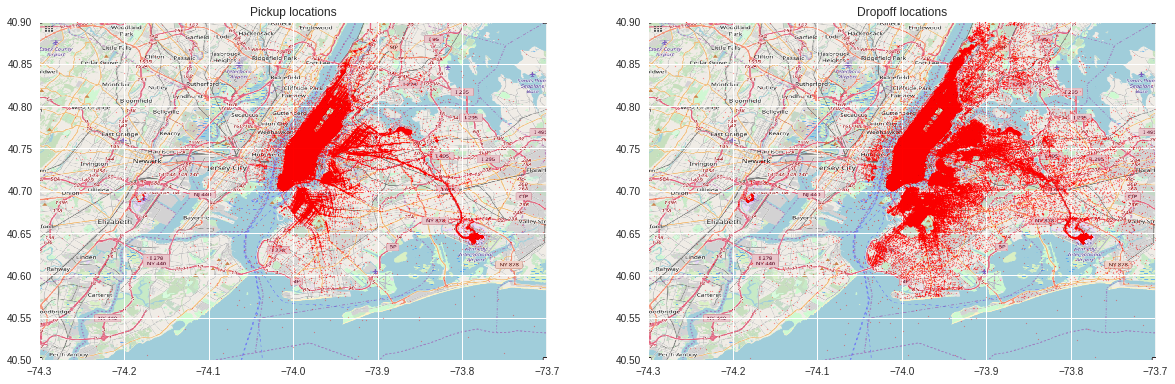

In [16]:
dados_BB_zoom = filtrar_pela_BB(chunk, BB_zoom)

plot_on_map(dados_BB_zoom, BB_zoom, nyc_mapa_zoom, s=1, alpha=0.3)

 **Como visto no gráfico acima, temos pontos em cima da água que são anomalias. Logo, devemos os remover**

Então, para remover os pontos acima da água podemos fazer o seguinte:

Vamos criar um mapa booleano terra/água




In [0]:
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

#plt.figure(figsize=(8,8))
#plt.imshow(nyc_mapa, zorder=0)
#plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.


def remove_datapoints_from_water(df, BB):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    #BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y   = lonlat_to_xy(df['pickup_longitude'], df['pickup_latitude'], 
                                        nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df['dropoff_longitude'], df['dropoff_latitude'], 
                                        nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    
   # pickup_y = pickup_y[pickup_y.value != 1262]

    
    # calculate boolean index    
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]

   
    # return only datapoints on land
    return df[idx]
 



 
dados_BB = remove_datapoints_from_water(dados_BB, BB)

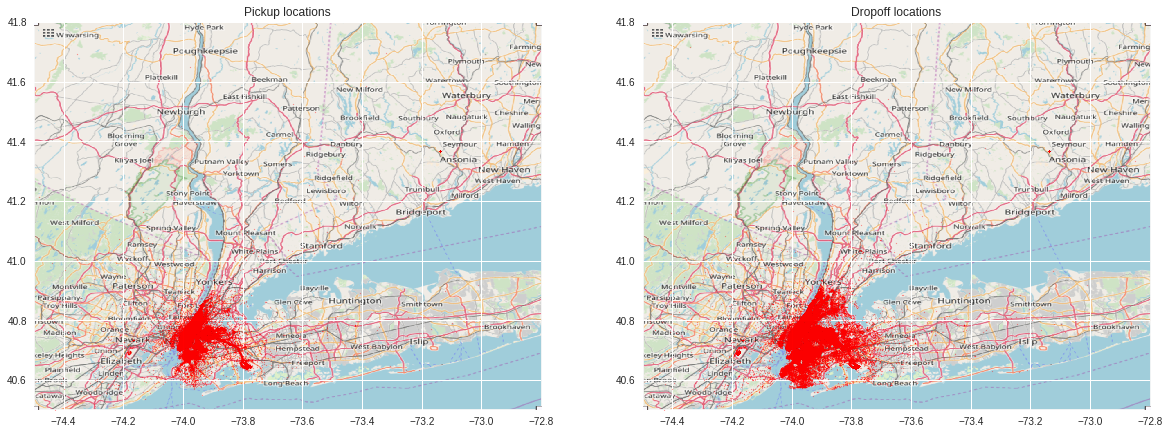

In [18]:
plot_on_map(dados_BB, BB, nyc_mapa, s=1, alpha=0.3)

In [0]:
chunk = dados_BB

In [20]:
# Agora, criaremos um indicador de distancia percorrida, bem como criarei mais colunas
# Com mais informação util, como Dia, Mês, Ano, hora, minuto, segundo


# Para calcularmos a distancia, se faz necessário usar a formula de haversine que pega dois pontos em uma esfera (latitude e longitude) e converte para distancia em metros

def haversine_1 (lat1, long1, lat2, long2):
  
  # Lambda é a longitude
  # Phi é a latitude
  R = 6371 # raio da terra em km

  phi_1 = np.radians(chunk[lat1])
  phi_2 = np.radians(chunk[lat2])

  delta_phi    = np.radians(chunk[lat2] - chunk[lat1])
  delta_lambda = np.radians(chunk[long2] - chunk[long1])

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km

  chunk['distancia'] = d 
  return d
                                 

haversine_1('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0          1.030764
1          8.450134
2          1.389525
3          2.799270
4          1.999157
5          3.787239
6          1.555807
7          4.155444
8          1.253232
9          2.849627
10         1.374577
12         0.717767
13         2.019384
14         1.671445
16         2.609774
17         1.511904
18         0.921952
19         0.399179
20         1.686861
21         2.292470
22         0.924296
23         1.403958
24         1.017773
25         2.531947
27         0.328771
28         4.073463
29         0.808153
30         0.871913
31         6.703551
32         9.403296
            ...    
999842     1.800660
999843    16.888650
999844     0.443274
999845     0.509990
999846     6.774274
999847     9.357706
999848     4.093045
999849     5.314221
999850     1.842736
999851     3.689741
999852     4.456025
999853     3.622864
999854     1.162477
999855     0.806466
999856     8.401025
999857     1.344648
999858     0.821492
999859     0.240398
999860     0.000000


In [0]:
# Removendo os NaNs

chunk = chunk.dropna(how = 'any', axis = 'rows')

In [0]:
# Distancia de Manhattan

# Vou usar essa métrica também pois ela representa melhor a distancia percorrida de fato pelo taxista

from math import atan2

def distance(coord1lat, coord1lon, coord2lat, coord2lon):
    R = 6373.0
    lat1 = np.radians(float(coord1lat))
    lon1 = np.radians(float(coord1lon))
    lat2 = np.radians(float(coord2lat))
    lon2 = np.radians(float(coord2lon))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * atan2(np.sqrt(a), np.sqrt(1 - a))
  
    distance = R * c

    return distance

def manhattan(coord1lat, coord1lon, coord2lat, coord2lon):
    d1=distance(coord1lat, coord2lon, coord2lat, coord2lon)
    d2=distance(coord1lat, coord1lon, coord1lat, coord2lon)
    
    return d1+d2
  
chunk['Manhattan dist']=chunk[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].apply(lambda x: manhattan(x[0], x[1], x[2], x[3]), axis=1)

In [0]:
# converter string para date_time, para obtermos os dados temporais

chunk['key']             = pd.to_datetime(chunk['key'])

chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'])

In [0]:
# Olhando a cara dos atributos dos dados após a conversão

chunk.dtypes

from datetime import datetime

In [0]:
def formatDateZ(Ano, Mes, Dia):
  return "{:%d/%m/%Y}".format(datetime(Ano,Mes,Dia))

In [0]:
# Separando os dados temporais para podermos visualizar-los melhor

chunk['Ano']           = chunk['pickup_datetime'].dt.year
chunk['Mes']           = chunk['pickup_datetime'].dt.month
chunk['Dia']           = chunk['pickup_datetime'].dt.day
chunk['Dia da semana'] = chunk['pickup_datetime'].dt.dayofweek
chunk['Horario']       = chunk['pickup_datetime'].dt.hour


In [0]:
chunk['Data'] = chunk[['Ano','Mes','Dia']].apply(lambda x: formatDateZ(x[0],x[1],x[2]), axis=1)

In [0]:
# Colocar variáveis de estado para
# se está de:
# noite
# madrugada

def noite(x):
  if ((x['Horario'] <=20) & (x['Horario'] >=17) ):
    return 1
  else:
    return 0

def madrugada(x):
  if ((x['Horario'] <= 5) | (x['Horario'] >=21) ):
    return 1
  else:
    return 0
  
chunk['Noite'] = chunk.apply(lambda x: noite(x), axis=1)
chunk['Madrugada'] = chunk.apply(lambda x: madrugada(x), axis=1)


Por fim, removerei as corridas em que não houve distância percorrida

In [0]:
chunk = chunk[chunk['distancia']      >=0.1]
chunk = chunk[chunk['Manhattan dist'] >=0.1]

Vamos ver como está o gráfico da taxa média em função dos dias

In [0]:
serie_temporal = chunk['Data'].drop_duplicates()
serie_temporal = serie_temporal.to_frame('Data')

df_temp = chunk[['Data','fare_amount']]

def precoMedio(Data):
  return np.mean(df_temp[df_temp['Data']==Data]['fare_amount'])

teste = pd.DataFrame(columns=['fare_amount'])

j = 0;



for data in serie_temporal['Data']:
  teste.loc[j] = np.mean(df_temp[df_temp['Data']==data]['fare_amount'])
  j = j + 1

In [0]:
serie_temporal_agora_vai = pd.DataFrame(columns=['Data'])

j = 0

for data in serie_temporal['Data']:
  serie_temporal_agora_vai.loc[j] = data
  j = j + 1

In [32]:
serie_temporal_agora_vai

Data
0     15/06/2009
1     05/01/2010
2     18/08/2011
3     21/04/2012
4     09/03/2010
5     06/01/2011
6     20/11/2012
7     04/01/2012
8     03/12/2012
9     02/09/2009
10    08/04/2012
11    06/11/2009
12    02/07/2013
13    05/04/2011
14    19/02/2014
15    22/07/2009
16    07/07/2010
17    06/12/2014
18    07/09/2010
19    12/02/2013
20    06/08/2009
21    06/12/2010
22    10/12/2009
23    21/06/2011
24    28/06/2011
25    04/05/2012
26    11/08/2013
27    21/06/2015
28    09/01/2009
29    07/09/2011
...          ...
2342  26/05/2013
2343  26/01/2015
2344  16/09/2013
2345  25/12/2014
2346  27/01/2015
2347  05/05/2013
2348  19/09/2014
2349  11/06/2011
2350  23/06/2010
2351  08/03/2015
2352  21/12/2009
2353  17/11/2013
2354  19/06/2015
2355  30/05/2010
2356  06/01/2013
2357  17/03/2014
2358  10/04/2014
2359  25/03/2011
2360  09/01/2012
2361  11/05/2010
2362  15/03/2010
2363  27/07/2009
2364  05/07/2014
2365  06/12/2013
2366  01/04/2011
2367  04/07/2013
2368  05/02/2010
2369  20/01/2015
2370  27/12/2010
2371  28/08/2011

[2372 rows x 1 columns]

In [0]:
ts_final = pd.concat([serie_temporal_agora_vai,teste], axis=1)

In [34]:
ts_final.head()

Data  fare_amount
0  15/06/2009    10.238210
1  05/01/2010     9.620460
2  18/08/2011    10.404656
3  21/04/2012    10.597104
4  09/03/2010     9.789224

In [35]:
ts_final.describe()

fare_amount
count  2372.000000
mean     11.323851
std       1.446254
min       8.145146
25%      10.099497
50%      10.871529
75%      12.629573
max      16.733484

In [0]:
# ordenar por data

ts_final['Data'] = pd.to_datetime(ts_final['Data'])

In [0]:
ts_final.sort_values(by='Data')
ts_final2 = ts_final.reset_index(drop=True)

 

<Figure size 576x396 with 0 Axes>

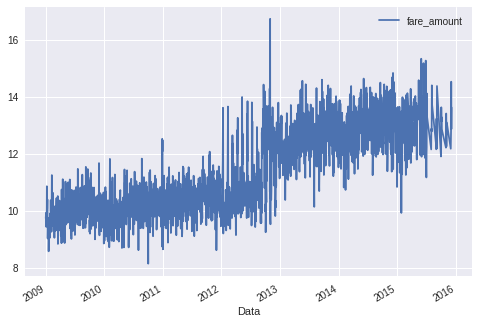

In [38]:
plt.figure()

ts_final2.plot(x='Data', y='fare_amount')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



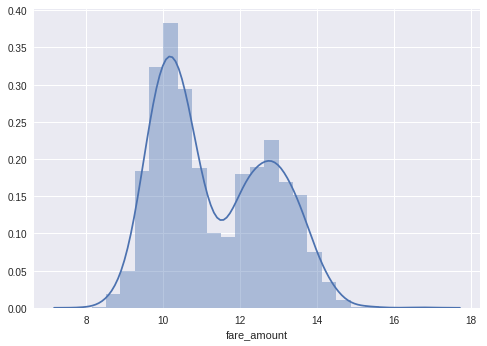

In [39]:
sbs.distplot(ts_final2['fare_amount'])

Agora vou criar um indicador de transito

Veja:

O preço da taxa é dado aproximadamente pela equação:

$Fare = \$2.50 + \$0.30 + \$0.5 \cdot isMadrugada(hora) + \$2.5 \cdot (Milhas\_Percorridas \ acima\ de \ 12mph (20km/h)\ ou\ por\ minuto\ quando\ abaixo\ de\ 20km/h) + \$1.00 \cdot rushHour(hora)$

Então, uma maneira de mensurar o transito enfretado durante a viagem será

$Preco\ Transito = Fare - Taxas\_Fixa - \$2.50\cdot Milhas\_Percorridas $

In [0]:
def precoTransito(Fare, Distancia, Rush, Madrugada):
  superFare = Fare - (2.5) - 2.5*Distancia*0.321869
  
  if (superFare >= 0.0):
    return superFare
  else:
    return 0
  
def coefTransito(index,dist):
  return index/dist

In [0]:
# Eu defini a função Hora do rush como o atributo Noite
# e a função Madrugada como o atributo Madrugada no dataframe

chunk['index transito'] = chunk[['fare_amount','Manhattan dist','Noite','Madrugada']].apply(lambda x: precoTransito(x[0],x[1],x[2],x[3]),axis=1)


Após a isso, criarei um coeficiente de transito que será dado por:

$$Coef = \frac{Preco\ transito}{Distancia\ percorrida (Manhattan)}$$

In [0]:
chunk['coef transito'] = chunk[['index transito','Manhattan dist']].apply(lambda x: coefTransito(x[0],x[1]),axis=1)

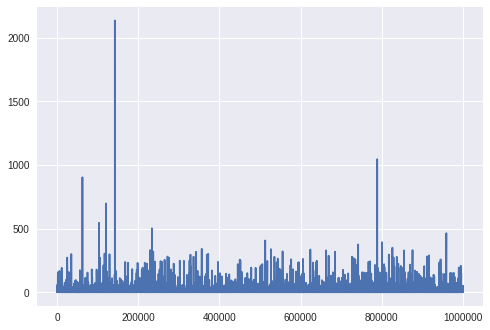

In [43]:
chunk['coef transito'].plot()

In [44]:
chunk['coef transito'].describe()

count    962571.000000
mean          1.586403
std           4.847702
min           0.000000
25%           0.758696
50%           1.175510
75%           1.779728
max        2137.759810
Name: coef transito, dtype: float64

In [0]:
chunk_sorted = chunk.sort_values(by='coef transito', ascending=False)

In [0]:
filtrado_chunk = chunk_sorted[chunk_sorted['coef transito'] <=10]

In [0]:
filtrado_chunk = filtrado_chunk.reset_index(drop=True)

In [48]:
filtrado_chunk.head()

key  fare_amount     pickup_datetime  \
0 2011-05-05 11:11:00.000000176         13.3 2011-05-05 11:11:00   
1 2014-05-21 17:33:34.000000300          4.0 2014-05-21 17:33:34   
2 2014-11-29 13:39:06.000000200          8.5 2014-11-29 13:39:06   
3 2011-07-08 22:13:00.000000200          6.5 2011-07-08 22:13:00   
4 2011-01-25 08:38:00.000000230          4.1 2011-01-25 08:38:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.978362        40.753193         -73.978735         40.744488   
1        -73.994452        40.750169         -73.995527         40.750603   
2        -73.983856        40.765138         -73.983266         40.760591   
3        -73.981698        40.778682         -73.978248         40.777965   
4        -73.971855        40.764132         -73.970765         40.763625   

   passenger_count  distancia  Manhattan dist   Ano  Mes  Dia  Dia da semana  \
0                5   0.968462        0.999685  2011    5    5              3   
1                2   0.102611        0.138857  2014    5   21              2   
2                1   0.508039        0.555466  2014   11   29              5   
3                1   0.301237        0.370337  2011    7    8              4   
4                1   0.107728        0.148222  2011    1   25              1   

   Horario        Data  Noite  Madrugada  index transito  coef transito  
0       11  05/05/2011      0          0        9.995581       9.998735  
1       17  21/05/2014      1          0        1.388265       9.997798  
2       13  29/11/2014      0          0        5.553031       9.997061  
3       22  08/07/2011      0          1        3.702000       9.996313  
4        8  25/01/2011      0          0        1.480730       9.989977

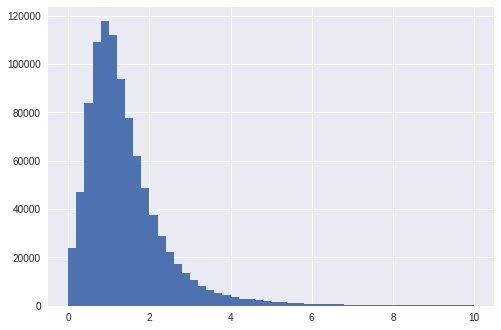

In [49]:
filtrado_chunk['coef transito'].hist(bins = 50)

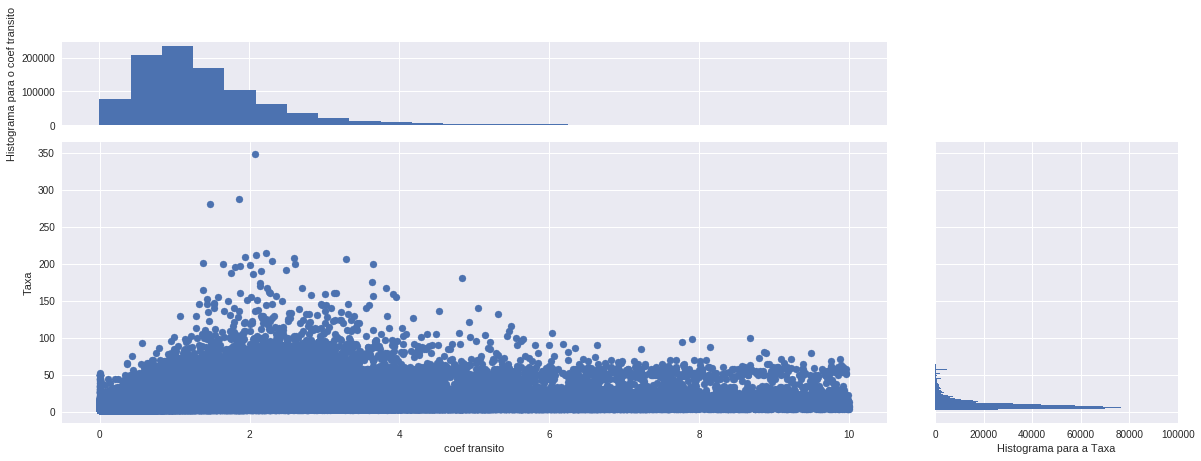

In [50]:
fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x=filtrado_chunk['coef transito'], y=filtrado_chunk['fare_amount'])
ax_marg_x.hist(filtrado_chunk['coef transito'], bins=24)
ax_marg_y.hist(filtrado_chunk['fare_amount'],orientation="horizontal",bins=500)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('coef transito')
ax_joint.set_ylabel('Taxa')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a Taxa')
ax_marg_x.set_ylabel('Histograma para o coef transito')
plt.show()

Observando os maiores valores de coeficiente de transito, vejo que dados com resíduos de distancia (< 0.1 ) estão sujando o banco de dados.

Porque, imagine que uma pessoa via pegar um taxi para andar menos de 100 metros e a taxa deles dão muito alta.

Para evitar essas anomalias, deletarei os dados onde a distancia <0.1

# **Análise exploratória de dados**

---



**Como é cobrada a taxa de taxi em NYC:**

1 - A taxa inicial é de **$2.50**

2 - Mais  **50 cents ** a cada 1/5 de Milha (0,321869 km) acima de 12 mph (19,3121 km/h) ou a cada minuto em tráfico devagar

3 - **50 cents**  de taxa adicional para todas viagens que terminam em NYC, Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange ou Putnam Counties

4 - ** 30 cents** de taxa de melhoramento

5 - ** 50 cents ** de taxa para tráfego entre **8pm** e **6am**

6 - ** $1.00 ** de taxa de hora do rush (**4pm ate 8pm**) em dias de semana, não se aplicando a feriados

7 -  Taxa de congestionamento de ** 2.50 ** (Taxi amarelo) , ** 2.75** (Taxi verde ou FHV) ou **75 cents** para corridas compartilhadas para todas as corridas que começam, terminam ou passam por Manhattan south of 96th street

8 - Pedágios e gorjetas são acrescidos caso necessário

**Hipóteses:**

1 - O Número de pessoas impacta no valor da taxa

2 - O horário o qual o taxi foi pego impacta no valor

3 - O dia da semana o qual o taxi foi pego impacta no valor

4 - O local de origem do taxi tem relação com a taxa?

5 - A distância percorrida impacta no valor da taxa?

6 - O ano impacta na taxa?



#**Análise de correlação dos dados**

---



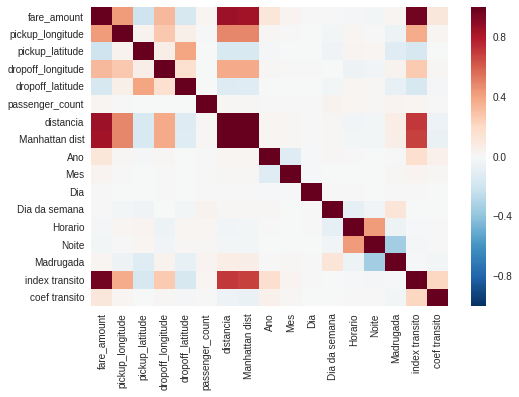

In [51]:
# Primeiro, vamos observar uma correlação dos dados para saber o que buscar de maneira mais eficiente

corr = chunk.corr()

sbs.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)

Por esse gráfico, já dá para criar uma noção sobre os principais fatores influenciadores da taxa:

    - Coordenadas de pickup

    - Coordenadas de dropoff

    - Distancia (euclidiana)

    - Distancia (Manhattan)

    - Ano

##**Hipótese 1**

---
O número de pessoas impacta no valor da taxa?


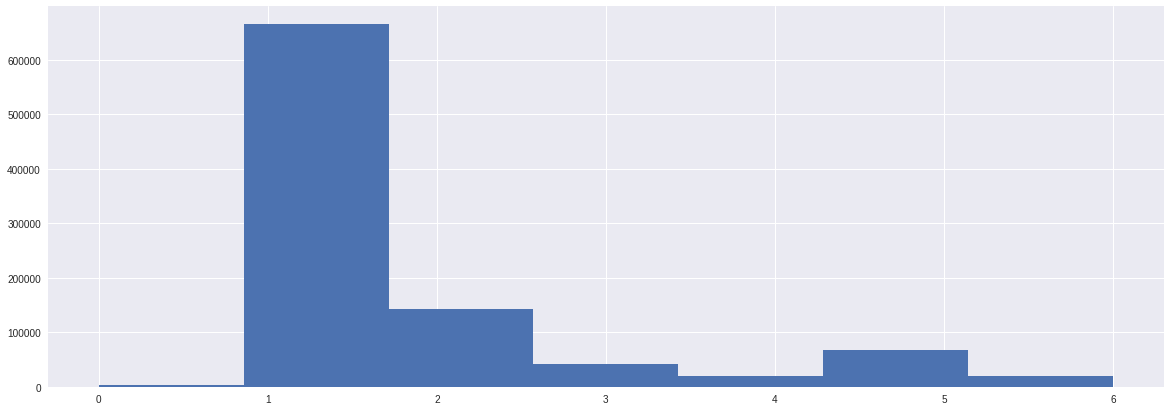

In [52]:
# Inicialmente, vamos ver a distribuição do número de pessoas

plt.figure(figsize=(20,7))

chunk['passenger_count'].hist(bins=7)

Text(0, 0.5, 'Taxa paga')

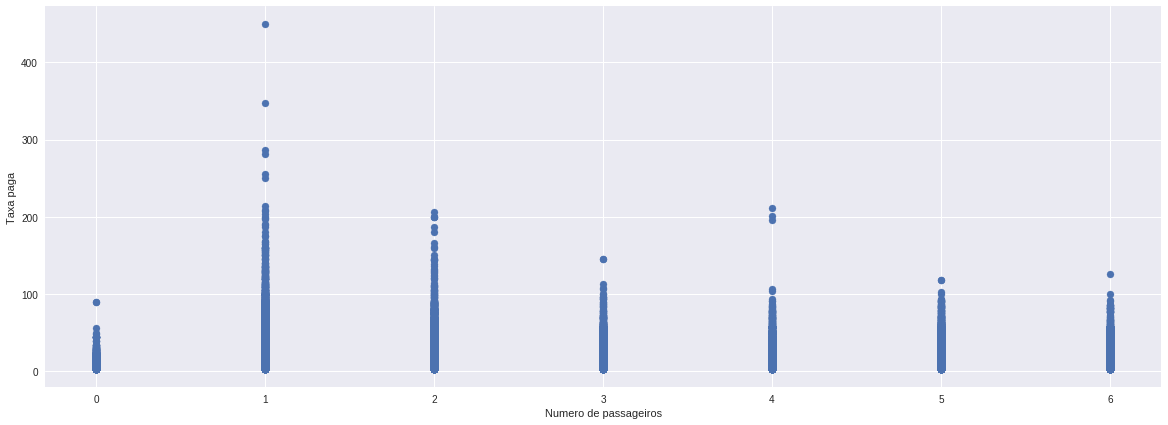

In [53]:
# Agora, é interessante ver como está a distribuição de número de passageiros x taxa paga

plt.figure(figsize=(20,7))

plt.scatter(x=chunk['passenger_count'], y=chunk['fare_amount'])
plt.xlabel('Numero de passageiros')
plt.ylabel('Taxa paga')

Dos dois gráficos, podemos inferir que a viagem de taxi para 1 passageiro é mais frequente. As taxas pagas mais altas também vem da viagem para 1 passageiro

#**Hipótese 2**

---

O horário impacta na taxa paga?

Text(0, 0.5, 'Frequencia')

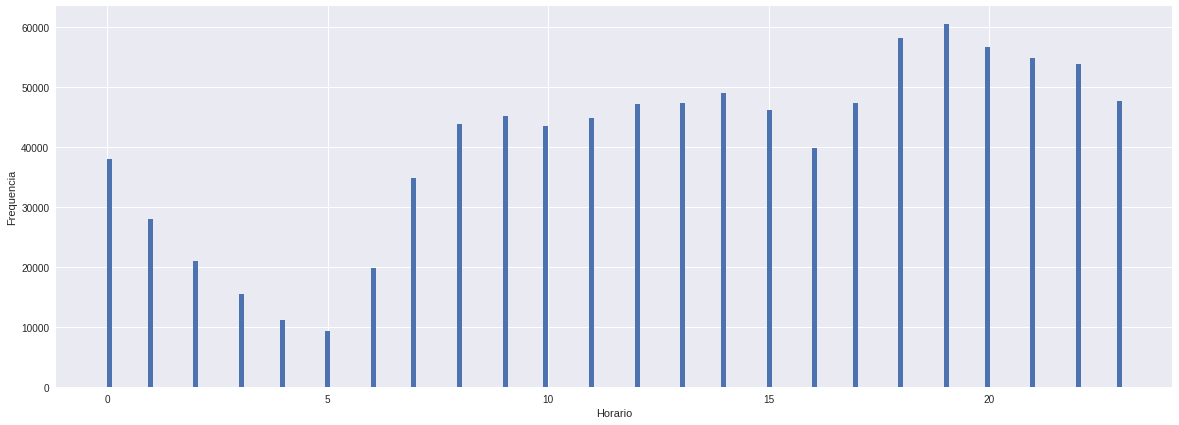

In [54]:
# Primeiro vamos estudar como está distribuida o horário os quais os taxis são pegos

plt.figure(figsize=(20,7))

chunk['Horario'].hist(bins=200)
plt.xlabel('Horario')
plt.ylabel('Frequencia')

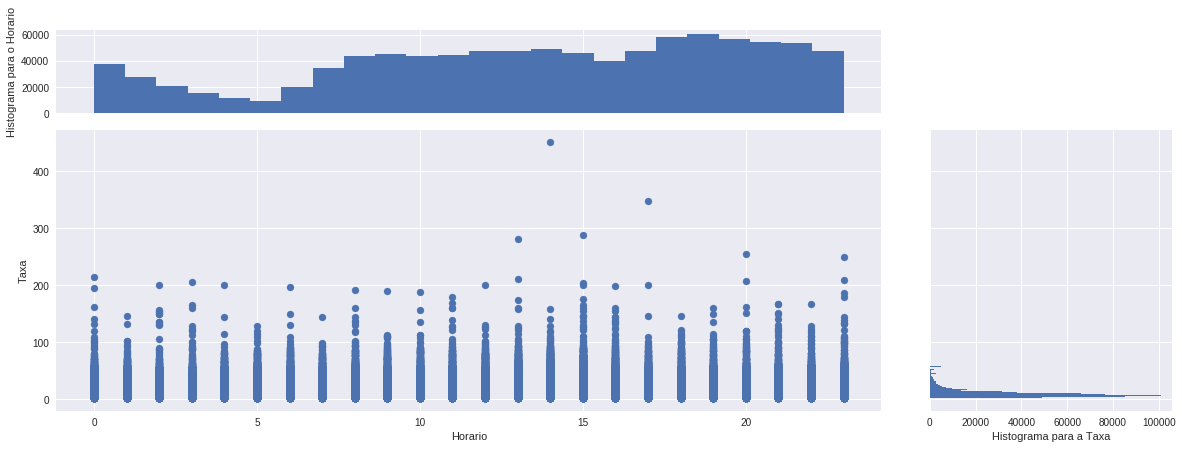

In [55]:


# plt.figure(figsize=(20,7))

# plt.scatter(x=chunk['Horario'], y=chunk['fare_amount'])
# plt.xlabel('Horario')
# plt.ylabel('Taxa paga')


# Vamos ver como fica a distribuição do preço pago pelo horário


fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x=chunk['Horario'], y=chunk['fare_amount'])
ax_marg_x.hist(chunk['Horario'], bins=24)
ax_marg_y.hist(chunk['fare_amount'],orientation="horizontal",bins=500)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Horario')
ax_joint.set_ylabel('Taxa')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a Taxa')
ax_marg_x.set_ylabel('Histograma para o Horario')
plt.show()




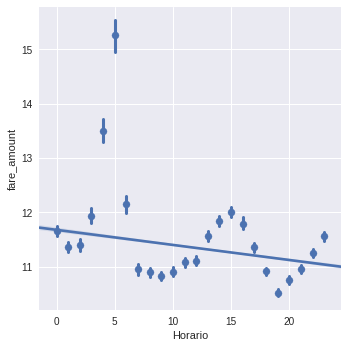

In [56]:
sbs.lmplot(x='Horario', y='fare_amount',data=chunk, x_estimator=np.mean)

(0, 20)

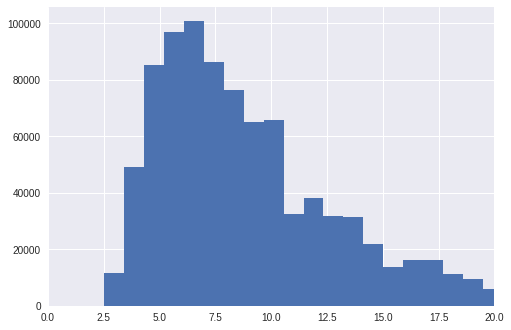

In [57]:
plt.hist(chunk['fare_amount'],bins=500)
plt.xlim((0,20))

In [58]:
chunk['fare_amount'].describe()

count    962571.000000
mean         11.302554
std           9.446071
min           2.500000
25%           6.000000
50%           8.500000
75%          12.500000
max         450.000000
Name: fare_amount, dtype: float64

Dos gráficos podemos inferir que ocorrem mais viagens entre as 18h e 21h, que é o horário em que geralmetne as pessoas voltam de seus trabalhos para casa. Todavia, o horário não parece impactar tanto no preço.

Também, vemos que a maioria das viagens custam, em média, 11.35 com um desvio padrão de 9.82


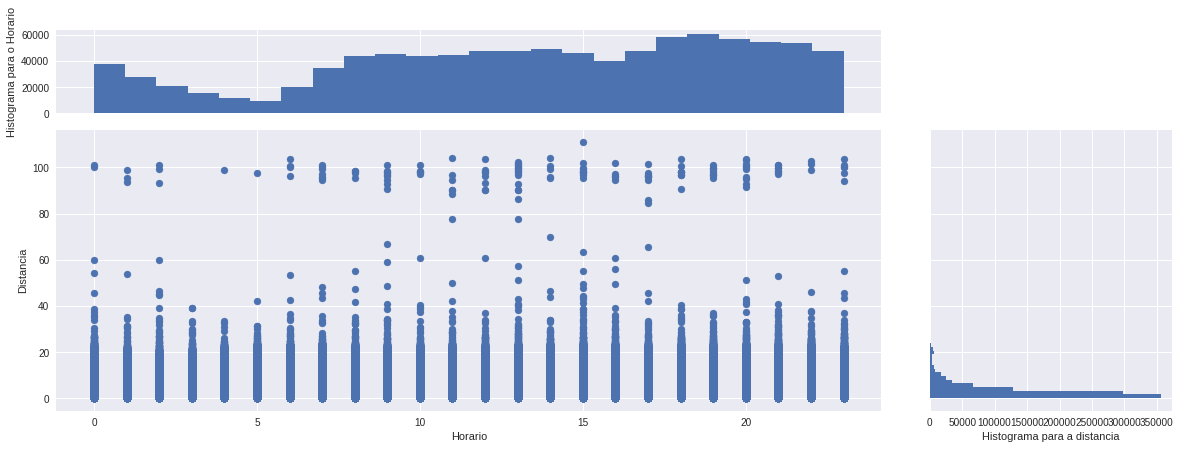

In [59]:
# Mas será que o horário impacta na distancia viajada?


fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x=chunk['Horario'], y=chunk['distancia'])
ax_marg_x.hist(chunk['Horario'], bins=24)
ax_marg_y.hist(chunk['distancia'],orientation="horizontal",bins=70)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Horario')
ax_joint.set_ylabel('Distancia')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a distancia')
ax_marg_x.set_ylabel('Histograma para o Horario')
plt.show()


In [0]:
#sbs.lmplot(x='Horario', y='distancia',data=chunk, x_estimator=np.mean)


Vemos assim a relação entre horário e distância viajada

#**Hipótese 3**


---
O dia da semana o qual o taxi foi pego impacta no valor?


Text(0, 0.5, 'Frequencia')

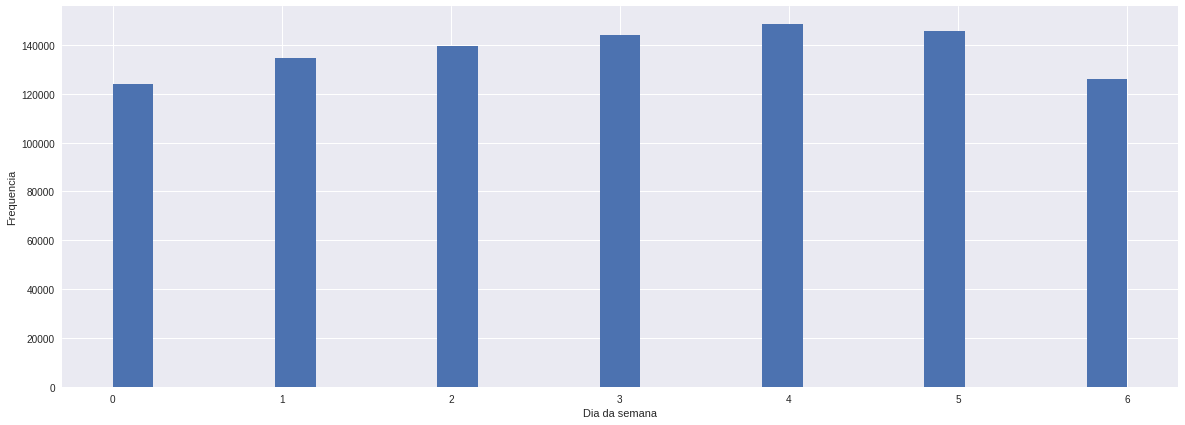

In [60]:
# Primeiro vamos estudar como está distribuida a demanda por taxis ao longo dos dias da semana

plt.figure(figsize=(20,7))

chunk['Dia da semana'].hist(bins=25)
plt.xlabel('Dia da semana')
plt.ylabel('Frequencia')

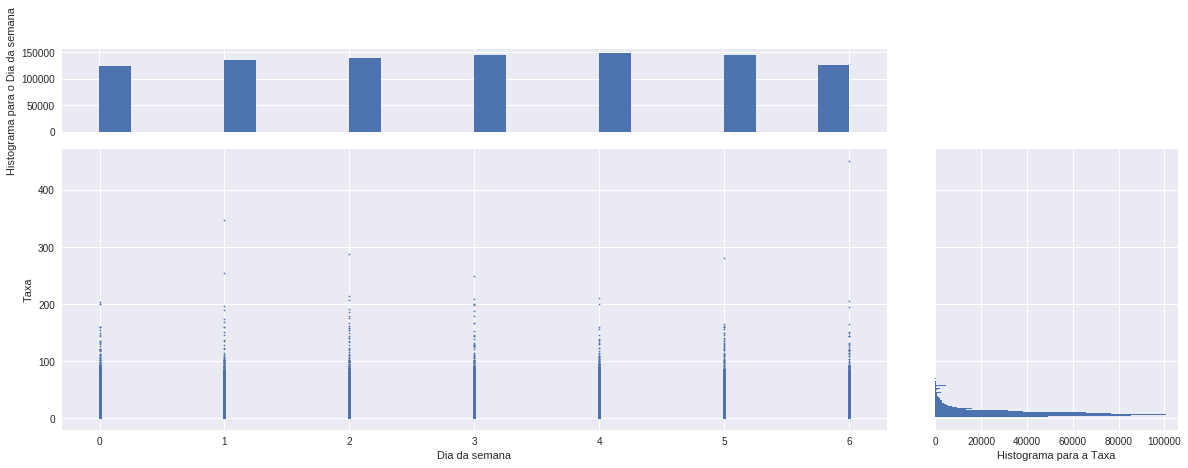

In [61]:
# Qual é a relação entre o dia da semana e ataxa paga?

fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])


ax_joint.scatter(x=chunk['Dia da semana'], y=chunk['fare_amount'],s=1.7)

ax_marg_x.hist(chunk['Dia da semana'], bins=24)
ax_marg_y.hist(chunk['fare_amount'],orientation="horizontal",bins=500)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Dia da semana')
ax_joint.set_ylabel('Taxa')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a Taxa')
ax_marg_x.set_ylabel('Histograma para o Dia da semana')
plt.show()


Podemos ver que o dia da semana que os taxis são mais requisitados é na quinta, 

(0, 25)

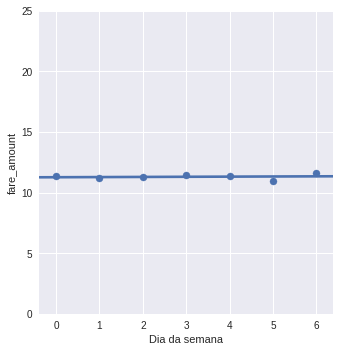

In [62]:
# fazendo uma análise usando o boxplot temos

sbs.lmplot(x='Dia da semana', y='fare_amount',data=chunk, x_estimator=np.mean)
plt.ylim((0,25))

Observando essa regressão, vemos que a taxa média é aproximadamente constante. Logo, a taxa não varia com o dia da semana 

#**Hipótese 4**


---

O local onde o taxi foi pego tem relação com a taxa?

In [0]:
#Vamos ver como fica um plot de densidade dos pickup e dropoff

def distance(lat1, long1, lat2, long2):
#     p = 0.017453292519943295 # Pi/180
#     a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
#     return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...
  R = 6371 # raio da terra em km

  phi_1 = np.radians(lat1)
  phi_2 = np.radians(lat2)

  delta_phi    = np.radians(lat2 - lat1)
  delta_lambda = np.radians(long2 - long1)

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km
  return d


  
# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays


bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(chunk.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(chunk.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(chunk.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(chunk.dropoff_latitude, bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

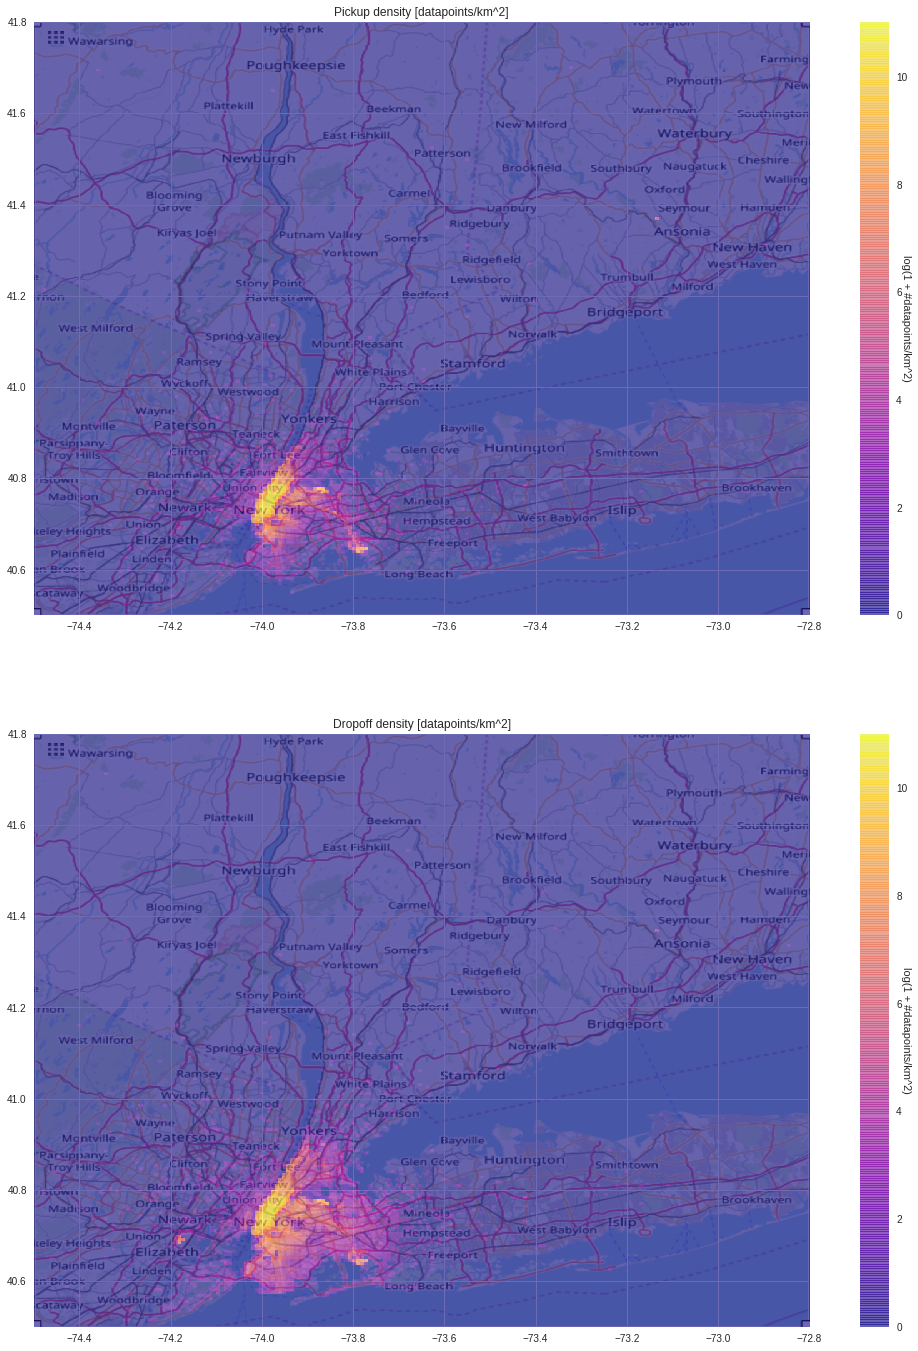

In [64]:
# Plot the density arrays
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
axs[0].imshow(nyc_mapa, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints/km^2]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints/km^2)', rotation=270)

axs[1].imshow(nyc_mapa, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints/km^2]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints/km^2)', rotation=270)


Observamos que temos 3 pontos mais afastados do centro de NYC (Manhattan). 

Ao procurar-los no google maps, vi que eles são 3 aeroportos: 

- Aeroporto John F. Kennedy (JKF)
  - Latitude: 40.6413
  - Longitude: -73.7781

- Aeroporto LaGuardia (LGA)
  - Latitude: 40.7769
  - Longitude:-73.8739

- Aeroporto Newark (EWR) 
  - Latitude: 40.7026
  - Longitude: -74.1878
  
  
Então, vamos analisar a taxa paga em função desses três focos de fluxo de taxi -- que estão mais evidentes no mapa

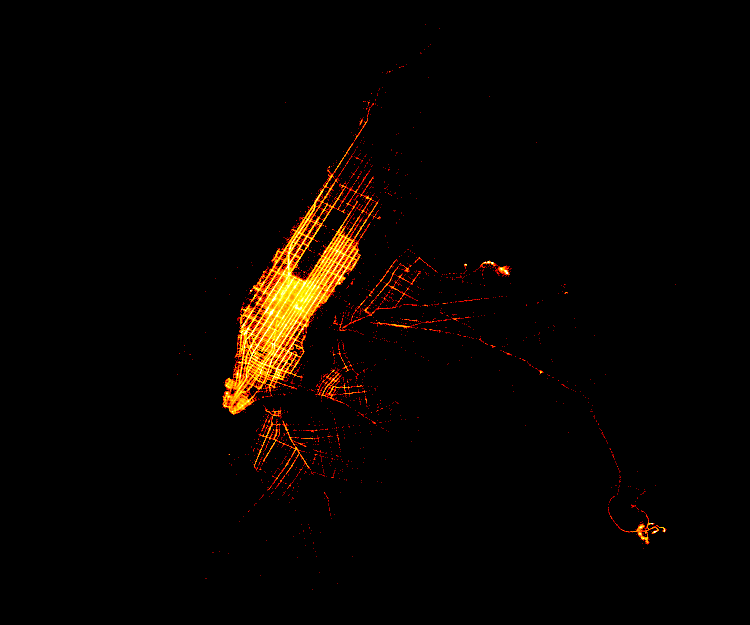

In [65]:
# função para plotar as coordenadas no mapa de NYC

def plot_data_points(longitude,latitude,data_frame,focus_point) :
    #plot dimensions
    x_range, y_range = ((-74.14,-73.73), (40.6,40.9))
    plot_width  = int(750)
    plot_height = int(plot_width//1.2)
    export  = partial(export_image, export_path="export", background="black")
    fig = figure(background_fill_color = "black")    
    #plot data points
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height,
                    x_range=x_range, y_range=y_range)
    agg = cvs.points(data_frame,longitude,latitude,
                      ds.count(focus_point))
    img = tf.shade(agg, cmap= Hot, how='eq_hist')
    image_xpt  =  tf.dynspread(img, threshold=0.5, max_px=4)
    return export(image_xpt,"NYCT_hot")


# taxa paga em função do ponto onde as pessoas pegam taxi
plot_data_points('pickup_longitude', 'pickup_latitude',chunk,'fare_amount')

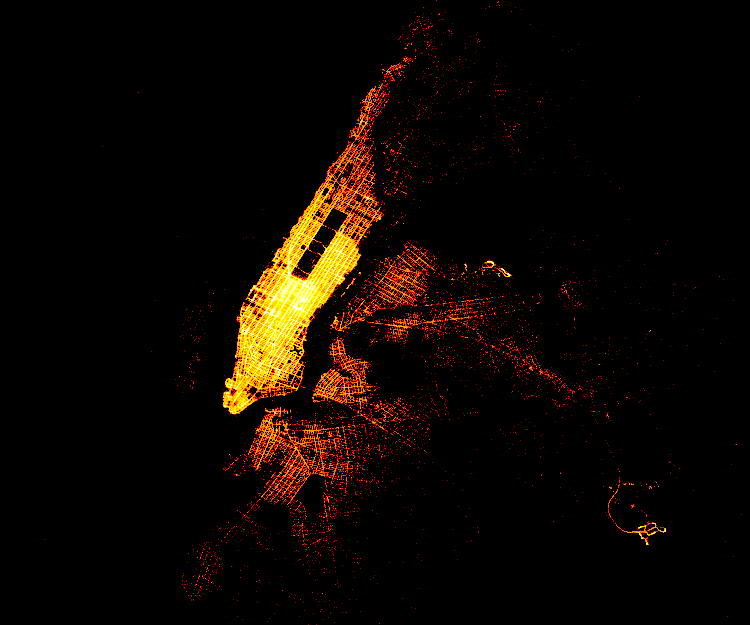

In [66]:
#Taxa paga em função do ponto em que são deixada as pessoas

plot_data_points('dropoff_longitude', 'dropoff_latitude',chunk,"fare_amount")

Observo que as maiores taxas são pagas por pessoas que:

- Vem ou vão para o JKF

- Vem ou vão para o LGA

- Estão no centro de Manhattan

Também, há esse fenômeno interessante de uma grande concentração de "pegar taxi" em Manhattan, e uma maior dispersão no "ponto de deixada" do taxi.
Possivelmente, as pessoas pegam taxi para se dirigir para suas casas. Explicando, assim o motivo da maior dispersão para os destinos em função da taxa paga.

In [0]:
# Vamos analisar brevemente como é o custo médio da tarifa para as pessoas que vão para os aeroportos

"""
- Aeroporto John F. Kennedy (JKF)
  - Latitude: 40.6413
  - Longitude: -73.7781

- Aeroporto LaGuardia (LGA)
  - Latitude: 40.7769
  - Longitude:-73.8739

- Aeroporto Newark (EWR) 
  - Latitude: 40.7026
  - Longitude: -74.1878
"""

# Pares Lat/long 

jkf = (40.6413, -73.7781)
lga = (40.7769, -73.8739)
ewr = (40.7026, -74.1878)


chunk['distancia JKF PICKUP']  = chunk.apply(lambda x: distance(jkf[0],jkf[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
chunk['distancia JKF DROPOFF'] = chunk.apply(lambda x: distance(jkf[0],jkf[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

chunk['distancia LGA PICKUP'] = chunk.apply(lambda x: distance(lga[0],lga[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
chunk['distancia LGA DROPOFF'] = chunk.apply(lambda x: distance(lga[0],lga[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

chunk['distancia EWR PICKUP'] = chunk.apply(lambda x: distance(ewr[0],ewr[1],x['pickup_latitude'],x['pickup_longitude']), axis=1)
chunk['distancia EWR DROPOFF'] = chunk.apply(lambda x: distance(ewr[0],ewr[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)



In [0]:
# Vamos ver como é a distribuição das viagens que partem dos aeroportos

# Primeiro vamos filtrar pelos destinos

indo_jkf   = chunk[chunk['distancia JKF PICKUP']  <2]
volta_jkf  = chunk[chunk['distancia JKF DROPOFF'] <2]

indo_lga   = chunk[chunk['distancia LGA PICKUP']  <2]
volta_lga  = chunk[chunk['distancia LGA DROPOFF'] <2]

indo_ewr   = chunk[chunk['distancia EWR PICKUP']  <2]
volta_ewr  = chunk[chunk['distancia EWR DROPOFF'] <2]

In [0]:
# Viagens que não vão para aeroporto algum

# remover os do jkf
not_aeroporto = chunk.drop(
                           indo_jkf.index, axis=0
                          )
not_aeroporto = chunk.drop(
                           volta_jkf.index, axis=0
                          )

# remover os do lga
not_aeroporto = chunk.drop(
                           indo_lga.index, axis=0
                          )
not_aeroporto = chunk.drop(
                           volta_lga.index, axis=0
                          )

# remover os do ewr
not_aeroporto = chunk.drop(
                           indo_ewr.index, axis=0
                          )
not_aeroporto = chunk.drop(
                           volta_ewr.index, axis=0
                          )


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



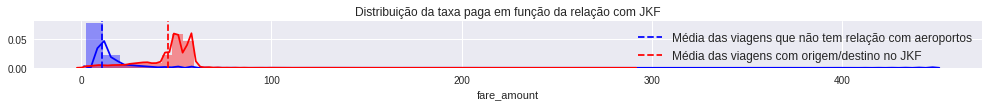

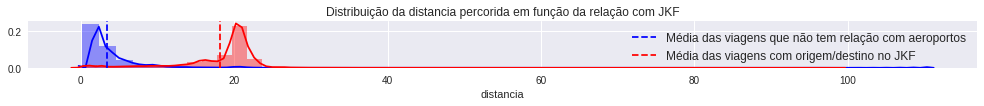

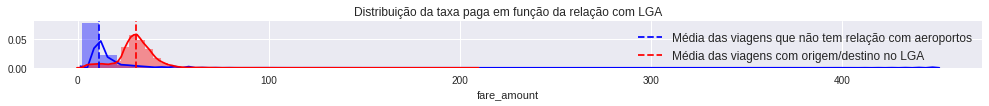

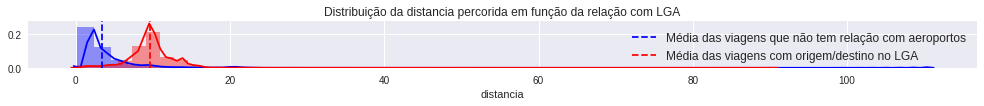

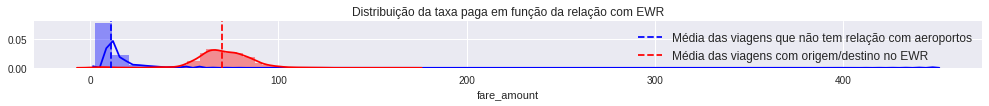

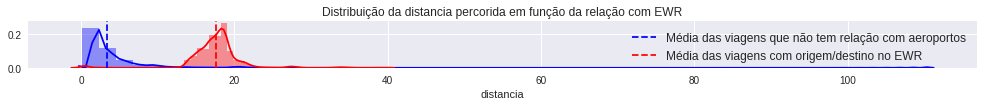

In [70]:
# Comparar a distribuição dos preços pagos e o aeroporto

# JKF

jkf_geral = pd.concat([indo_jkf, volta_jkf])


plt.figure(figsize= (17,6))
plt.subplot(611)

sbs.distplot(not_aeroporto['fare_amount'], color='b', bins=50)
sbs.distplot(jkf_geral['fare_amount'], color='r', bins=50)


plt.axvline(not_aeroporto['fare_amount'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(jkf_geral['fare_amount'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no JKF'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da taxa paga em função da relação com JKF")
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(612)

sbs.distplot(not_aeroporto['distancia'], color='b', bins=50)
sbs.distplot(jkf_geral['distancia'], color='r', bins=50)


plt.axvline(not_aeroporto['distancia'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(jkf_geral['distancia'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no JKF'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da distancia percorida em função da relação com JKF")
plt.show()
# FIM DA ANALISE DO JKF

# LGA

lga_geral = pd.concat([indo_lga, volta_lga])


plt.figure(figsize= (17,6))
plt.subplot(613)

sbs.distplot(not_aeroporto['fare_amount'], color='b', bins=50)
sbs.distplot(lga_geral['fare_amount'], color='r', bins=50)


plt.axvline(not_aeroporto['fare_amount'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(lga_geral['fare_amount'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no LGA'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da taxa paga em função da relação com LGA")
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(614)

sbs.distplot(not_aeroporto['distancia'], color='b', bins=50)
sbs.distplot(lga_geral['distancia'], color='r', bins=50)


plt.axvline(not_aeroporto['distancia'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(lga_geral['distancia'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no LGA'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da distancia percorida em função da relação com LGA")
plt.show()

# Fim da análise do LGA

# EWR

ewr_geral = pd.concat([indo_ewr, volta_ewr])


plt.figure(figsize= (17,6))
plt.subplot(615)

sbs.distplot(not_aeroporto['fare_amount'], color='b', bins=50)
sbs.distplot(ewr_geral['fare_amount'], color='r', bins=50)


plt.axvline(not_aeroporto['fare_amount'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(ewr_geral['fare_amount'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no EWR'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da taxa paga em função da relação com EWR")
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(616)

sbs.distplot(not_aeroporto['distancia'], color='b', bins=50)
sbs.distplot(ewr_geral['distancia'], color='r', bins=50)


plt.axvline(not_aeroporto['distancia'].mean(),
            color='b', linestyle='dashed', label='Média das viagens que não tem relação com aeroportos'
           )
plt.axvline(ewr_geral['distancia'].mean(),
            color='r', linestyle='dashed', label='Média das viagens com origem/destino no EWR'
           )


plt.legend(loc= 'best', prop= {'size' : 12})

plt.title("Distribuição da distancia percorida em função da relação com EWR")
plt.show()


###Dos gráficos acima, observa-se que:

1 -  Em geral, corridas que estão relacionadas com aeroportos são mais caras
    
    - isso era esperado porque, como citado anteriormente, para corridas relacionadas a aeroportos existem taxas extras
    
    - Também, devido a maior distância que os aeroportos possuem do centro de NYC (Manhattan) impactará numa taxa maior
    
2 -  Corridas pegas no aeroporto LGA tendem a ser mais baratas

    - Uma possível justificativa é o fato do aeroporto está mais próximo a áreas residenciais/hotel -- ao contrário dos outros

3 - Corridas pegas no aeroporto EWR tendem a percorrer a ser mais caras
    
    - Novamente, devido a distância que o aeroporto tem das áreas residenciais e de hotel.

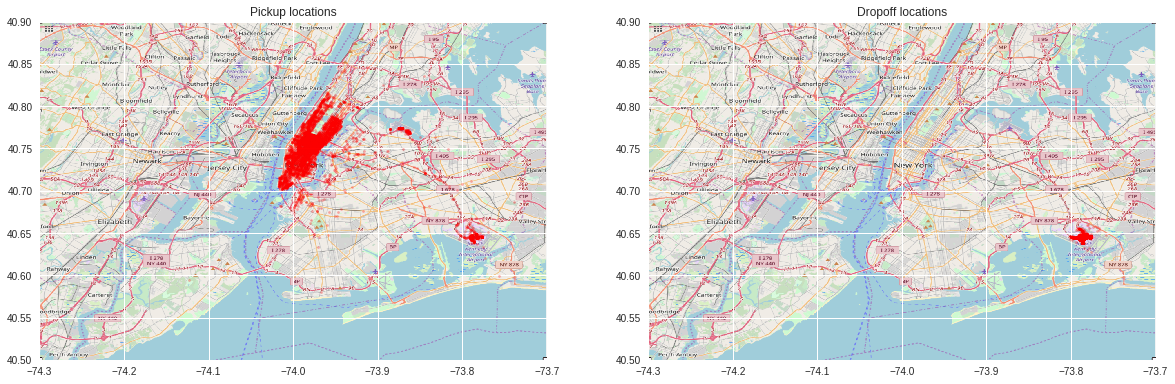

In [71]:
# Destinos relacioados ao JKF
plot_on_map(volta_jkf, BB_zoom, nyc_mapa_zoom, s=5, alpha=0.3)



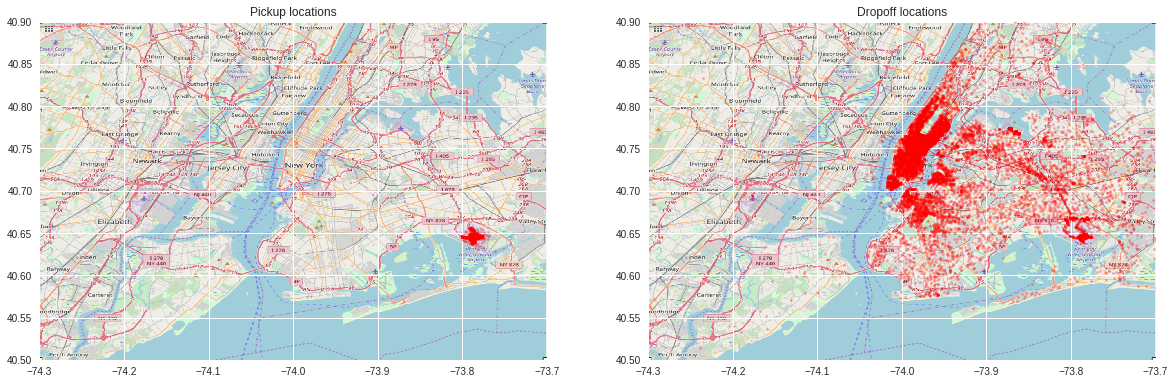

In [72]:
# Origens relacioados ao JKF
plot_on_map(indo_jkf, BB_zoom, nyc_mapa_zoom, s=5, alpha=0.3)


Observando estes gráficos, confirmo a minha hipótese de que 

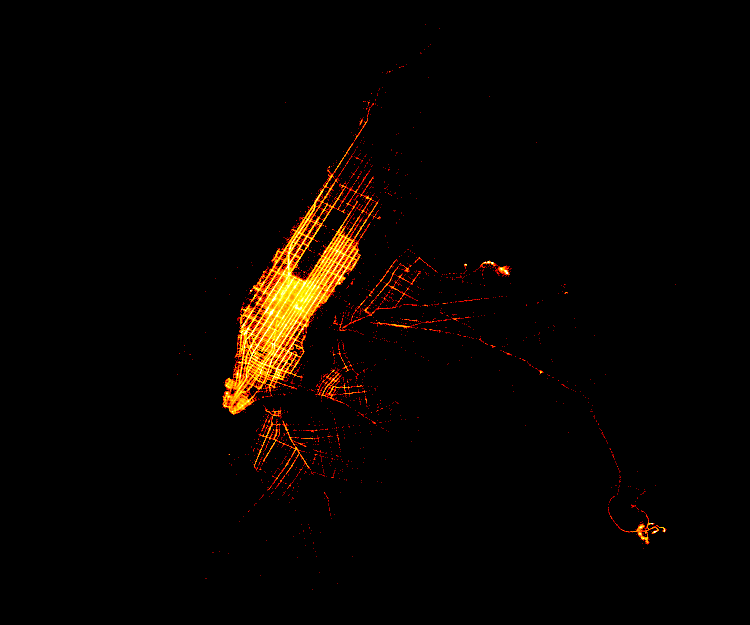

In [73]:
# Outra análise interessante a se fazer:

plot_data_points('pickup_longitude', 'pickup_latitude',chunk,'distancia')

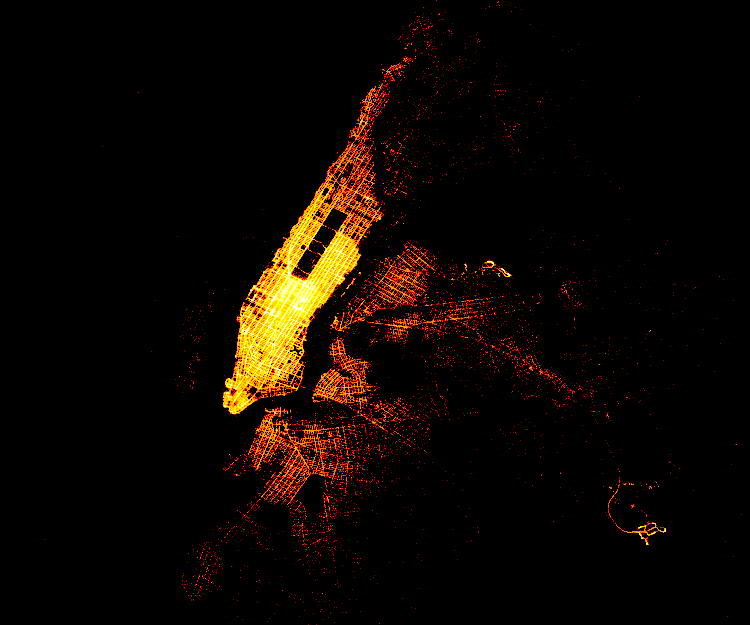

In [74]:
plot_data_points('dropoff_longitude', 'dropoff_latitude',chunk,"distancia")

Obtemos um comportamento parecido quando plotamos o mesmo gráfico, contudo com a intensidade do brilho variando de acordo com a distancia percorrida. Evidenciando, assim, que a distância está correlacionada com a taxa paga

# **Hipótese 5**

---

A distância influencia na taxa?

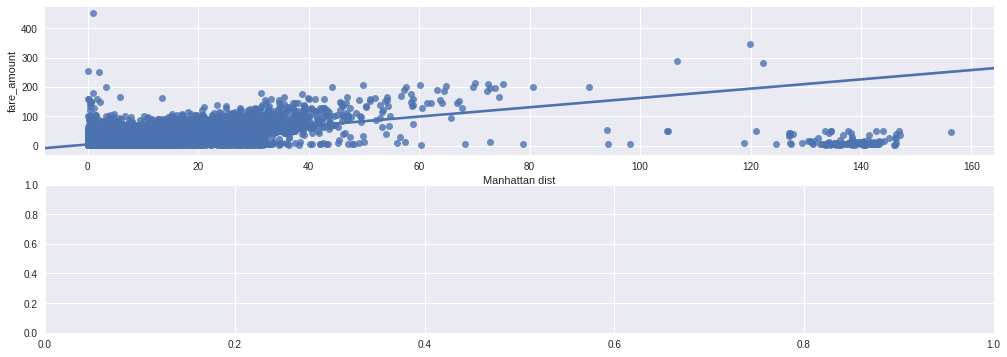

In [75]:
# Primeiro, farei uma regressão linear para ver como a taxa paga se comporta em função das distâncias

plt.figure(figsize= (17,6))
plt.subplot(211)

sbs.regplot(x='Manhattan dist',y= 'fare_amount', data=chunk)

plt.subplot(212)
#sbs.regplot(x='distancia',y= 'fare_amount', data=chunk, x_estimator=np.mean)

Dos gráficos, observamos o que já era suspeito: de que tais métricas impactam fortemente no valor da taxa. 

Agora, vamos desprezar os elementos cuja taxa paga foi zero e refazer esta análise


# Machine Learning

---

Usarei, por simplicidade, um modelo de regressão linear. Entretanto, sei que este modelo não será tão preciso -- todavia, por falta de tempo, irei utilizar-lo.

In [227]:
test = pd.read_csv('test.csv')
test.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count       9914.000000      9914.000000        9914.000000       9914.000000   
mean         -73.974722        40.751041         -73.973657         40.751743   
std            0.042774         0.033541           0.039072          0.035435   
min          -74.252193        40.573143         -74.263242         40.568973   
25%          -73.992501        40.736125         -73.991247         40.735254   
50%          -73.982326        40.753051         -73.980015         40.754065   
75%          -73.968013        40.767113         -73.964059         40.768757   
max          -72.986532        41.709555         -72.990963         41.696683   

       passenger_count  
count      9914.000000  
mean          1.671273  
std           1.278747  
min           1.000000  
25%           1.000000  
50%           1.000000  
75%           2.000000  
max           6.000000

In [228]:
# Adicionando features que usei na EDA para o teste
teste = test
#teste = remove_datapoints_from_water(test, BB)
print(len(teste))
#teste['key']             = pd.to_datetime(teste['key'])

teste['pickup_datetime'] = pd.to_datetime(teste['pickup_datetime'])

teste['Ano'] = teste['pickup_datetime'].dt.year
teste['Mes'] = teste['pickup_datetime'].dt.month
teste['Dia'] = teste['pickup_datetime'].dt.day
teste['Dia da semana'] = teste['pickup_datetime'].dt.dayofweek
teste['Horario'] = teste['pickup_datetime'].dt.hour

teste['Noite'] = teste.apply(lambda x: noite(x), axis=1)
teste['Madrugada'] = teste.apply(lambda x: madrugada(x), axis=1)



def haversine_2 (lat1, long1, lat2, long2):
  
  # Lambda é a longitude
  # Phi é a latitude
  R = 6371 # raio da terra em km

  phi_1 = np.radians(teste[lat1])
  phi_2 = np.radians(teste[lat2])

  delta_phi    = np.radians(teste[lat2] - teste[lat1])
  delta_lambda = np.radians(teste[long2] - teste[long1])

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km

  teste['distancia'] = d 
  return d
                                 

haversine_2('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')





teste['distancia JKF PICKUP']  = teste.apply(lambda x: distance(jkf[0],jkf[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
teste['distancia JKF DROPOFF'] = teste.apply(lambda x: distance(jkf[0],jkf[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

teste['distancia LGA PICKUP']  = teste.apply(lambda x: distance(lga[0],lga[1],x['pickup_latitude'], x['pickup_longitude']), axis=1)
teste['distancia LGA DROPOFF'] = teste.apply(lambda x: distance(lga[0],lga[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

teste['distancia EWR PICKUP']  = teste.apply(lambda x: distance(ewr[0],ewr[1],x['pickup_latitude'],x['pickup_longitude']), axis=1)
teste['distancia EWR DROPOFF'] = teste.apply(lambda x: distance(ewr[0],ewr[1],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

teste['Manhattan dist']=teste[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].apply(lambda x: manhattan(x[0], x[1], x[2], x[3]), axis=1)


9914


In [206]:
teste.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count       9914.000000      9914.000000        9914.000000       9914.000000   
mean         -73.974722        40.751041         -73.973657         40.751743   
std            0.042774         0.033541           0.039072          0.035435   
min          -74.252193        40.573143         -74.263242         40.568973   
25%          -73.992501        40.736125         -73.991247         40.735254   
50%          -73.982326        40.753051         -73.980015         40.754065   
75%          -73.968013        40.767113         -73.964059         40.768757   
max          -72.986532        41.709555         -72.990963         41.696683   

       passenger_count          Ano          Mes          Dia  Dia da semana  \
count      9914.000000  9914.000000  9914.000000  9914.000000    9914.000000   
mean          1.671273  2011.815816     6.857979    16.194170       2.852834   
std           1.278747     1.803347     3.353272     8.838482       1.994451   
min           1.000000  2009.000000     1.000000     1.000000       0.000000   
25%           1.000000  2010.000000     4.000000     9.000000       1.000000   
50%           1.000000  2012.000000     7.000000    16.000000       3.000000   
75%           2.000000  2014.000000    10.000000    25.000000       5.000000   
max           6.000000  2015.000000    12.000000    31.000000       6.000000   

           Horario        Noite    Madrugada    distancia  \
count  9914.000000  9914.000000  9914.000000  9914.000000   
mean     13.467420     0.185193     0.358483     3.435371   
std       6.868584     0.388473     0.479579     3.972374   
min       0.000000     0.000000     0.000000     0.000000   
25%       8.000000     0.000000     0.000000     1.298277   
50%      15.000000     0.000000     0.000000     2.217412   
75%      19.000000     0.000000     1.000000     4.045302   
max      23.000000     1.000000     1.000000    99.996040   

       distancia JKF PICKUP  distancia JKF DROPOFF  distancia LGA PICKUP  \
count           9914.000000            9914.000000           9914.000000   
mean              20.878818              20.929775              9.752915   
std                3.827187               3.306016              3.479695   
min                0.417705               0.402312              0.306009   
25%               20.572284              20.526043              8.404119   
50%               21.200739              21.194582              9.676112   
75%               21.887736              21.923372             11.086912   
max              136.009319             134.582379            127.511147   

       distancia LGA DROPOFF  distancia EWR PICKUP  distancia EWR DROPOFF  \
count            9914.000000           9914.000000            9914.000000   
mean                9.688770             18.965080              19.131950   
std                 3.297537              4.310460               3.971212   
min                 0.282954             11.830174               0.753725   
25%                 8.324952             17.032813              17.192401   
50%                 9.491799             18.301590              18.563860   
75%                10.980490             19.917681              20.365438   
max               126.136929            150.449351             149.144800   

       Manhattan dist  
count     9914.000000  
mean         4.427912  
std          5.311167  
min          0.000000  
25%          1.653606  
50%          2.849530  
75%          5.242645  
max        141.072932

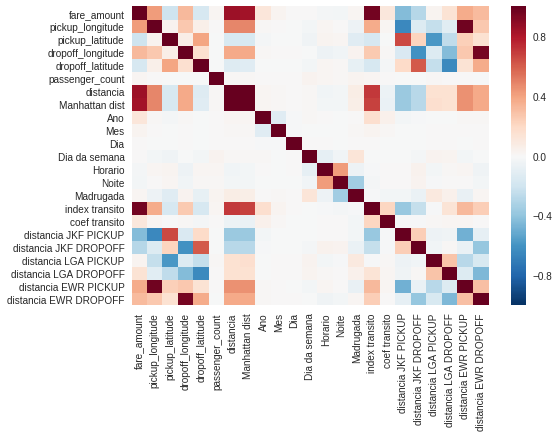

In [78]:
corr = chunk.corr()

sbs.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)

In [0]:
# eliminando features zoadas do teste
test_block  = teste.drop(['distancia EWR PICKUP','distancia EWR DROPOFF','distancia LGA DROPOFF','distancia LGA PICKUP','distancia JKF DROPOFF','distancia JKF PICKUP','passenger_count','Ano','Dia','Dia da semana','Horario','Noite','Madrugada','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude','Mes','key','pickup_datetime'], axis=1)

features_para_dropar = [
                         'Data',
                         'index transito',     # se colocar essas coisas o sistema 
                         'coef transito',      # vai ficar não causal
                         'passenger_count',
                         'Ano',
#                         'Dia',
                         'Dia da semana',
                         'Horario',
#                         'Noite',
#                         'Madrugada',
                         'dropoff_latitude',
                         'dropoff_longitude',
                         'pickup_latitude',
                         'pickup_longitude',
                         'Mes',
                         'key',
                         'pickup_datetime'
                       ]

# eliminando features que não servirão para o treino
train_block = chunk.drop(features_para_dropar, axis=1)


In [0]:
# fazendo teste depois da filtragem com o coeficiente de transito
# eliminando features que não servirão para o treino
#train_block = filtrado_chunk.drop(['Data','index transito','coef transito','passenger_count','Ano','Dia','Dia da semana','Horario','Noite','Madrugada','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude','Mes','key','pickup_datetime'], axis=1)

In [0]:
test_block = test_block.dropna()
train_block = train_block.dropna()
train_obj   = train_block['fare_amount']

train_block = train_block.drop(['fare_amount'], axis=1)

In [103]:
test_block.head()

distancia  Manhattan dist
0   2.323260        2.903583
1   2.425353        3.216919
2   0.618628        0.811186
3   1.961033        2.580432
4   5.387301        6.938274

In [104]:
train_block.head()

distancia  Manhattan dist  Dia  Noite  Madrugada  distancia JKF PICKUP  \
0   1.030764        1.233324   15      1          0             10.504346   
1   8.450134       10.965087    5      0          0             21.523172   
2   1.389525        1.907507   18      0          1             21.807027   
3   2.799270        3.149046   21      0          1             20.369738   
4   1.999157        2.716032    9      0          0             21.330886   

   distancia JKF DROPOFF  distancia LGA PICKUP  distancia LGA DROPOFF  \
0               9.538054              6.664018               7.683303   
1              23.071126             14.021749               8.890126   
2              21.690922              9.328918              10.307357   
3              22.192143             10.706872              10.127635   
4              21.850063              7.993447               7.009536   

   distancia EWR PICKUP  distancia EWR DROPOFF  
0             29.025869              29.200615  
1             14.509607              19.662123  
2             18.469139              17.400778  
3             17.249715              17.648839  
4             19.888969              21.462669

In [105]:
# Regressão linear

from sklearn.linear_model import LinearRegression

regressao = LinearRegression()
regressao.fit(train_block, train_obj)

regressao_pred = regressao.predict(test_block)


ValueError: ignored

In [0]:
reg_df = pd.DataFrame({'fare_amount':regressao_pred} )

In [106]:
reg_df.head(50)


fare_amount
0      9.027969
1      8.932963
2      5.064117
3      7.970907
4     15.669117
5     10.483334
6      5.862490
7     47.392930
8     12.065065
9      5.984579
10     8.836410
11    13.426990
12     5.159367
13     8.064703
14     9.408199
15    14.237787
16     4.428156
17     8.840520
18     5.646753
19     4.797312
20     7.054103
21     7.984602
22     6.797397
23     7.629934
24    16.433386
25     6.033851
26    32.377851
27    23.466273
28     6.359996
29    13.173951
30    10.786288
31     6.286870
32     6.523858
33    10.716384
34     8.306877
35     6.856673
36     6.524947
37     5.836782
38     7.930857
39     5.369403
40    18.491938
41     8.887116
42    16.577789
43     9.319910
44     4.942151
45    10.170890
46     6.033859
47     6.775006
48     6.097453
49     5.185390

**Random forest**

---

Fazendo análises com distancia apenas

Todavia, observar depois com outras features e filtrar melhor com o coef transito


In [0]:
# eliminando features zoadas do teste
#test_block  = teste.drop(['distancia EWR PICKUP','distancia EWR DROPOFF','distancia LGA DROPOFF','distancia LGA PICKUP','distancia JKF DROPOFF','distancia JKF PICKUP','passenger_count','Ano','Dia','Dia da semana','Horario','Noite','Madrugada','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude','Mes','key','pickup_datetime'], axis=1)

# eliminando features que não servirão para o treino
#train_block = chunk.drop(['Data','index transito','coef transito','distancia EWR PICKUP','distancia EWR DROPOFF','distancia LGA DROPOFF','distancia LGA PICKUP','distancia JKF DROPOFF','distancia JKF PICKUP','passenger_count','Ano','Dia','Dia da semana','Horario','Noite','Madrugada','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude','Mes','key','pickup_datetime'], axis=1)


# eliminando features zoadas do teste

features_teste_para_dropar = [
#                               'Data',
#                               'index transito',     # se colocar essas coisas o sistema 
#                               'coef transito',      # vai ficar não causal
                               'passenger_count',
                               'Ano',
#                              'Dia',
                               'Dia da semana',
                               'Horario',
#                               'Noite',
#                               'Madrugada',
                               'dropoff_latitude',
                               'dropoff_longitude',
                               'pickup_latitude',
                               'pickup_longitude',
                               'Mes',
                               'key',
                               'pickup_datetime',
#                               'distancia EWR PICKUP',
#                               'distancia EWR DROPOFF',
#                               'distancia LGA DROPOFF',
#                               'distancia LGA PICKUP',
#                               'distancia JKF DROPOFF',
#                               'distancia JKF PICKUP'
                             ]

test_block  = teste.drop(features_teste_para_dropar, axis=1)

features_para_dropar = [
                         'Data',
                         'index transito',     # se colocar essas coisas o sistema 
                         'coef transito',      # vai ficar não causal
                         'passenger_count',
                         'Ano',
#                         'Dia',
                         'Dia da semana',
                         'Horario',
#                         'Noite',
#                         'Madrugada',
                         'dropoff_latitude',
                         'dropoff_longitude',
                         'pickup_latitude',
                         'pickup_longitude',
                         'Mes',
                         'key',
                         'pickup_datetime',
#                         'distancia EWR PICKUP',
#                         'distancia EWR DROPOFF',
#                         'distancia LGA DROPOFF',
#                         'distancia LGA PICKUP',
#                         'distancia JKF DROPOFF',
#                         'distancia JKF PICKUP'
                       ]


# eliminando features que não servirão para o treino
train_block = chunk.drop(features_para_dropar, axis=1)



In [0]:
train_X, train_target = train_test_split(train_block)

In [209]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, oob_score=True, n_jobs=-1)

train_values, train_valid = train_test_split(train_block, test_size=0.1, random_state=30111997)

RF.fit(
        train_values.drop('fare_amount',axis=1),
        train_values['fare_amount']
      )

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
RF_predict = RF.predict(train_valid.drop('fare_amount', axis=1))

In [211]:
RF_predict

array([13.7394636 ,  7.42013075,  9.78866877, ...,  6.40967697,
        4.69509422,  6.79480282])

In [0]:
# Fazer  o gridsearch

from sklearn.model_selection import GridSearchCV

param_grid = {
               'bootstrap': [True],
               'max_depth': [80, 90, 100, 110],
               'max_features': [2,3],
               'min_samples_leaf': [3,4,5],
               'min_samples_split': [8, 10, 12],
               'n_estimators':  [10, 20, 30, 40]
             }

RF_GS = RandomForestRegressor()

# comeca o gridsearch

grid_search = GridSearchCV(estimator = RF_GS, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)


grid_search.fit(
                 train_values.drop('fare_amount',axis=1),
                 train_values['fare_amount']
               )


In [0]:
from sklearn.metrics import accuracy_score

teste_score = train_valid.drop(['fare_amount'],axis=1)
target_score = train_valid['fare_amount']
score = RF.score( 
                  teste_score,
                  target_score
                )

In [213]:
score

0.8390831303618353

In [0]:
# Testar com o banco de testes
submit = RF.predict(test_block)

aaa = pd.DataFrame(
                   {
                    'key':test.key,
                    'fare_amount':submit  
                   },
                    columns = ['key', 'fare_amount']
                  )

In [232]:
test_block = test_block[train_block.drop('fare_amount').columns]

ValueError: ignored

In [221]:
train_block.head(5)

fare_amount  distancia  Manhattan dist  Dia  Noite  Madrugada  \
0          4.5   1.030764        1.233324   15      1          0   
1         16.9   8.450134       10.965087    5      0          0   
2          5.7   1.389525        1.907507   18      0          1   
3          7.7   2.799270        3.149046   21      0          1   
4          5.3   1.999157        2.716032    9      0          0   

   distancia JKF PICKUP  distancia JKF DROPOFF  distancia LGA PICKUP  \
0             10.504346               9.538054              6.664018   
1             21.523172              23.071126             14.021749   
2             21.807027              21.690922              9.328918   
3             20.369738              22.192143             10.706872   
4             21.330886              21.850063              7.993447   

   distancia LGA DROPOFF  distancia EWR PICKUP  distancia EWR DROPOFF  
0               7.683303             29.025869              29.200615  
1               8.890126             14.509607              19.662123  
2              10.307357             18.469139              17.400778  
3              10.127635             17.249715              17.648839  
4               7.009536             19.888969              21.462669

**XGBoosting**

---



In [225]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# CRoss-validation
params = {
    # Parameters that we are going to tune.
    'max_depth': 8, #Result of tuning with CV
    'eta':.03, #Result of tuning with CV
    'subsample': 1, #Result of tuning with CV
    'colsample_bytree': 0.8, #Result of tuning with CV
    # Other parameters
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 1
}
"""
^^^^^^

ESsa parte acima eu peguei pronto para poder entender melhor como o xboost funciona, 
depois lembre de fazer o tuning usando o cross-validation 
"""

x_train, x_test, y_train, y_test = train_test_split(train_block.drop(columns=['fare_amount']), train_block['fare_amount'], random_state=42, test_size = 0.01)

def XGBmodel (x_train, x_test, y_train, y_test, params):
  matrix_train = xgb.DMatrix(x_train, label=y_train)
  matrix_test  = xgb.DMatrix(x_test, label=y_test)
                                                    
  model = xgb.train(
                    params=params,
                    dtrain=matrix_train,
                    num_boost_round = 5000,
                    early_stopping_rounds=10,
                    evals=[(matrix_test,'teste')]
                   )
                                   
  return model
                                                    
model = XGBmodel(x_train, x_test, y_train, y_test, params)                                                   

[0]	teste-rmse:13.8491
Will train until teste-rmse hasn't improved in 10 rounds.
[1]	teste-rmse:13.4635
[2]	teste-rmse:13.0934
[3]	teste-rmse:12.7351
[4]	teste-rmse:12.3852
[5]	teste-rmse:12.0467
[6]	teste-rmse:11.7182
[7]	teste-rmse:11.4009
[8]	teste-rmse:11.0945
[9]	teste-rmse:10.7995
[10]	teste-rmse:10.512
[11]	teste-rmse:10.2375
[12]	teste-rmse:9.97021
[13]	teste-rmse:9.71148
[14]	teste-rmse:9.47255
[15]	teste-rmse:9.23025
[16]	teste-rmse:8.99882
[17]	teste-rmse:8.77263
[18]	teste-rmse:8.55439
[19]	teste-rmse:8.34361
[20]	teste-rmse:8.14287
[21]	teste-rmse:7.94685
[22]	teste-rmse:7.75659
[23]	teste-rmse:7.57409
[24]	teste-rmse:7.39939
[25]	teste-rmse:7.23048
[26]	teste-rmse:7.06975
[27]	teste-rmse:6.9119
[28]	teste-rmse:6.76213
[29]	teste-rmse:6.61518
[30]	teste-rmse:6.47423
[31]	teste-rmse:6.34204
[32]	teste-rmse:6.21222
[33]	teste-rmse:6.08792
[34]	teste-rmse:5.97
[35]	teste-rmse:5.85658
[36]	teste-rmse:5.74524
[37]	teste-rmse:5.63802
[38]	teste-rmse:5.53683
[39]	teste-rmse:5.438

In [0]:
prediction_xgb = model.predict(xgb.DMatrix(test_block[x_train.columns]), ntree_limit= model.best_ntree_limit)

In [234]:
prediction_xgb

array([ 9.105315 ,  9.33745  ,  4.930725 , ..., 49.401783 , 18.32691  ,
        6.2675147], dtype=float32)

In [0]:
submit = prediction_xgb

aaa = pd.DataFrame(
                   {
                    'key':test.key,
                    'fare_amount':submit  
                   },
                    columns = ['key', 'fare_amount']
                  )

aaa.to_csv('submission.csv', index=False)

In [236]:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission.csv -m "Primeira tentativa"

100% 369k/369k [00:04<00:00, 83.6kB/s]
Successfully submitted to New York City Taxi Fare Prediction